In [ ]:
!pip install audio2numpy
!pip install librosa

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=172d5eb15a1feb603facbbf910efd09f3221a75e0b10f7ae2fb195a08395ae96
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import scipy
from scipy import fftpack
import scipy.io as sio
import audio2numpy as a2n
import librosa
import librosa.display

Задание 1, 2, 3

Реализовать вейвлеты Морле, “Мексиканская шляпа”, Хаара во временном пространстве. Посмотреть их
спектр.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


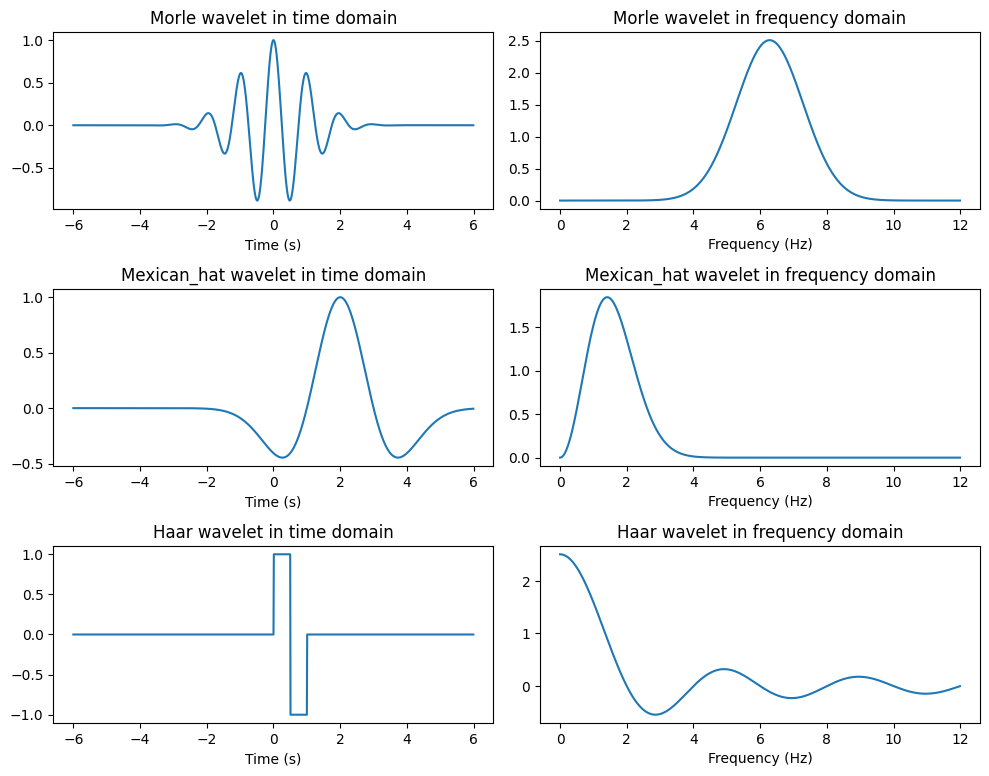

In [ ]:
def wavelet_function(t, wavelet_type):
    if wavelet_type == "Morle":
        a = 2
        return np.exp(-((t**2)/a)) * np.exp(1j*2*np.pi*t)
    elif wavelet_type == "Mexican_hat":
        return (1-(t - 2)**2)*np.exp(-((t - 2)**2/2))
    elif wavelet_type == "Haar":
        if t>=0 and t<1/2:
            return 1
        if t>=1/2 and t<1:
            return -1
        if t<0 or t>=1:
            return 0
    else:
        raise ValueError("Invalid wavelet_type. Use 'Morle', 'Mexican_hat', or 'Haar'.")

def wavelet_freq(w, wavelet_type):
    if wavelet_type == "Morle":
        a = np.sqrt(2)
        a2 = 2
        return a*np.sqrt(np.pi)*np.exp(-(a2*(2*np.pi-w)**2/4))
    elif wavelet_type == "Mexican_hat":
        return np.sqrt(2*np.pi)*w**2*np.exp(-(w**2/2))
    elif wavelet_type == "Haar":
        return np.sqrt(2*np.pi)*np.sinc(w/2)
    else:
        raise ValueError("Invalid wavelet_type. Use 'Morle', 'Mexican_hat', or 'Haar'.")

time = np.arange(-6, 6, 0.01)
freq = np.arange(0, 12, 0.01)

wavelet_types = ["Morle", "Mexican_hat", "Haar"]

plt.figure(figsize=(10, 10))

for i, wavelet_type in enumerate(wavelet_types, start=1):
    wavelet_time = [wavelet_function(t, wavelet_type) for t in time]
    wavelet_freqs = [wavelet_freq(w, wavelet_type) for w in freq]

    plt.subplot(4, 2, 2*i-1)
    plt.plot(time, wavelet_time)
    plt.xlabel('Time (s)')
    plt.title(f'{wavelet_type} wavelet in time domain')

    plt.subplot(4, 2, 2*i)
    plt.plot(freq, wavelet_freqs)
    plt.xlabel('Frequency (Hz)')
    plt.title(f'{wavelet_type} wavelet in frequency domain')

plt.tight_layout()
plt.show()


Задание 4. Рассмотреть произвольный сигнал с шумом.

Реализовать свертку сигнала с вейвлетами Морле, вейвлетом “Мексиканская шляпа” и
вейвлетом Хаара.

Осуществить фильтрацию сигналов с помощью этих 3-х вейвлетов.

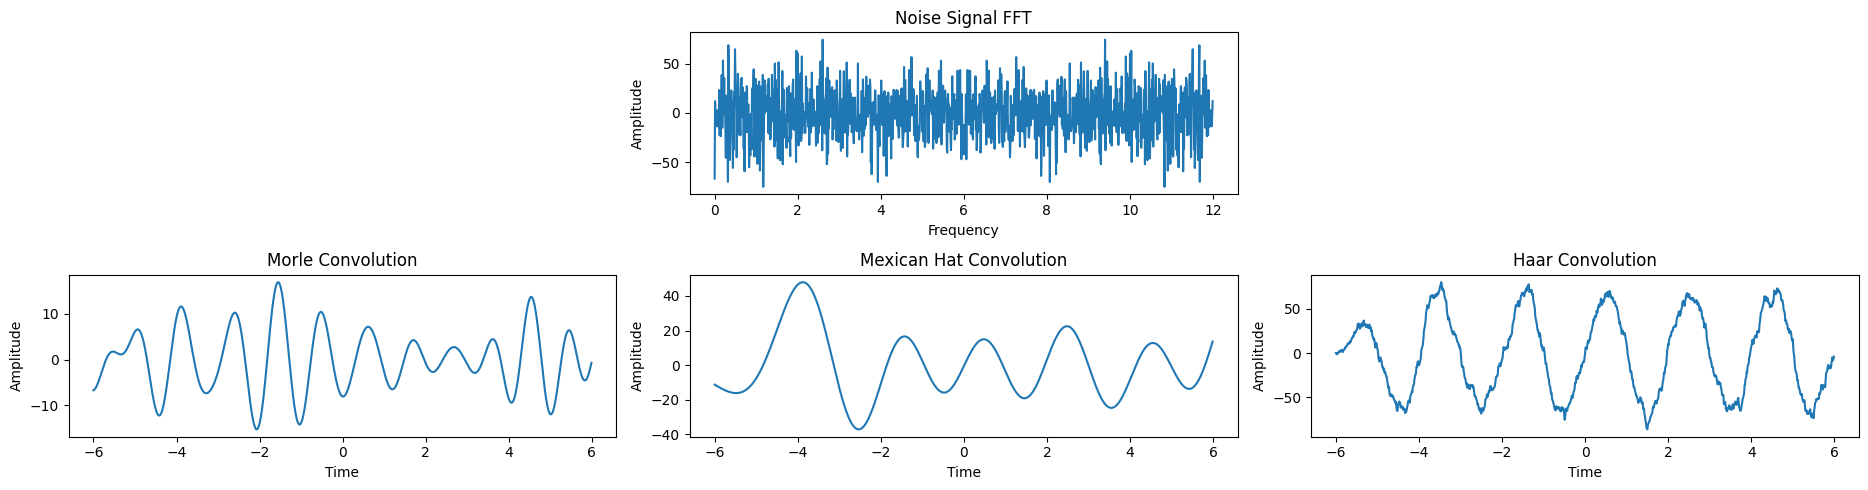

In [ ]:
time = np.arange(-6, 6, 0.01)
y_noise = np.random.normal(0,1,len(time))
y = np.sin(time * np.pi)
signal = y+y_noise

morle_conv = np.convolve(signal, [wavelet_function(t, "Morle") for t in time], mode='same')
mexican_conv = np.convolve(signal, [wavelet_function(t, "Mexican_hat") for t in time], mode='same')
haar_conv = np.convolve(signal, [wavelet_function(t, "Haar") for t in time], mode='same')

plt.figure(figsize=(25, 5))

plt.subplot(2, 4, 2)
plt.plot(freq, np.fft.fft(signal))
plt.title('Noise Signal FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 4, 5)
plt.plot(time, morle_conv)
plt.title('Morle Convolution')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(2, 4, 6)
plt.plot(time, mexican_conv)
plt.title('Mexican Hat Convolution')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(2, 4, 7)
plt.plot(time, haar_conv)
plt.title('Haar Convolution')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

Задание 4. На рис 4.(а) приведен сигнал, частота которого меняется со временем. На рис 4.(б)
представлена спектрограмма данного сигнала, которая получена в результате сверки
сигнала с вейвлетом Морле.

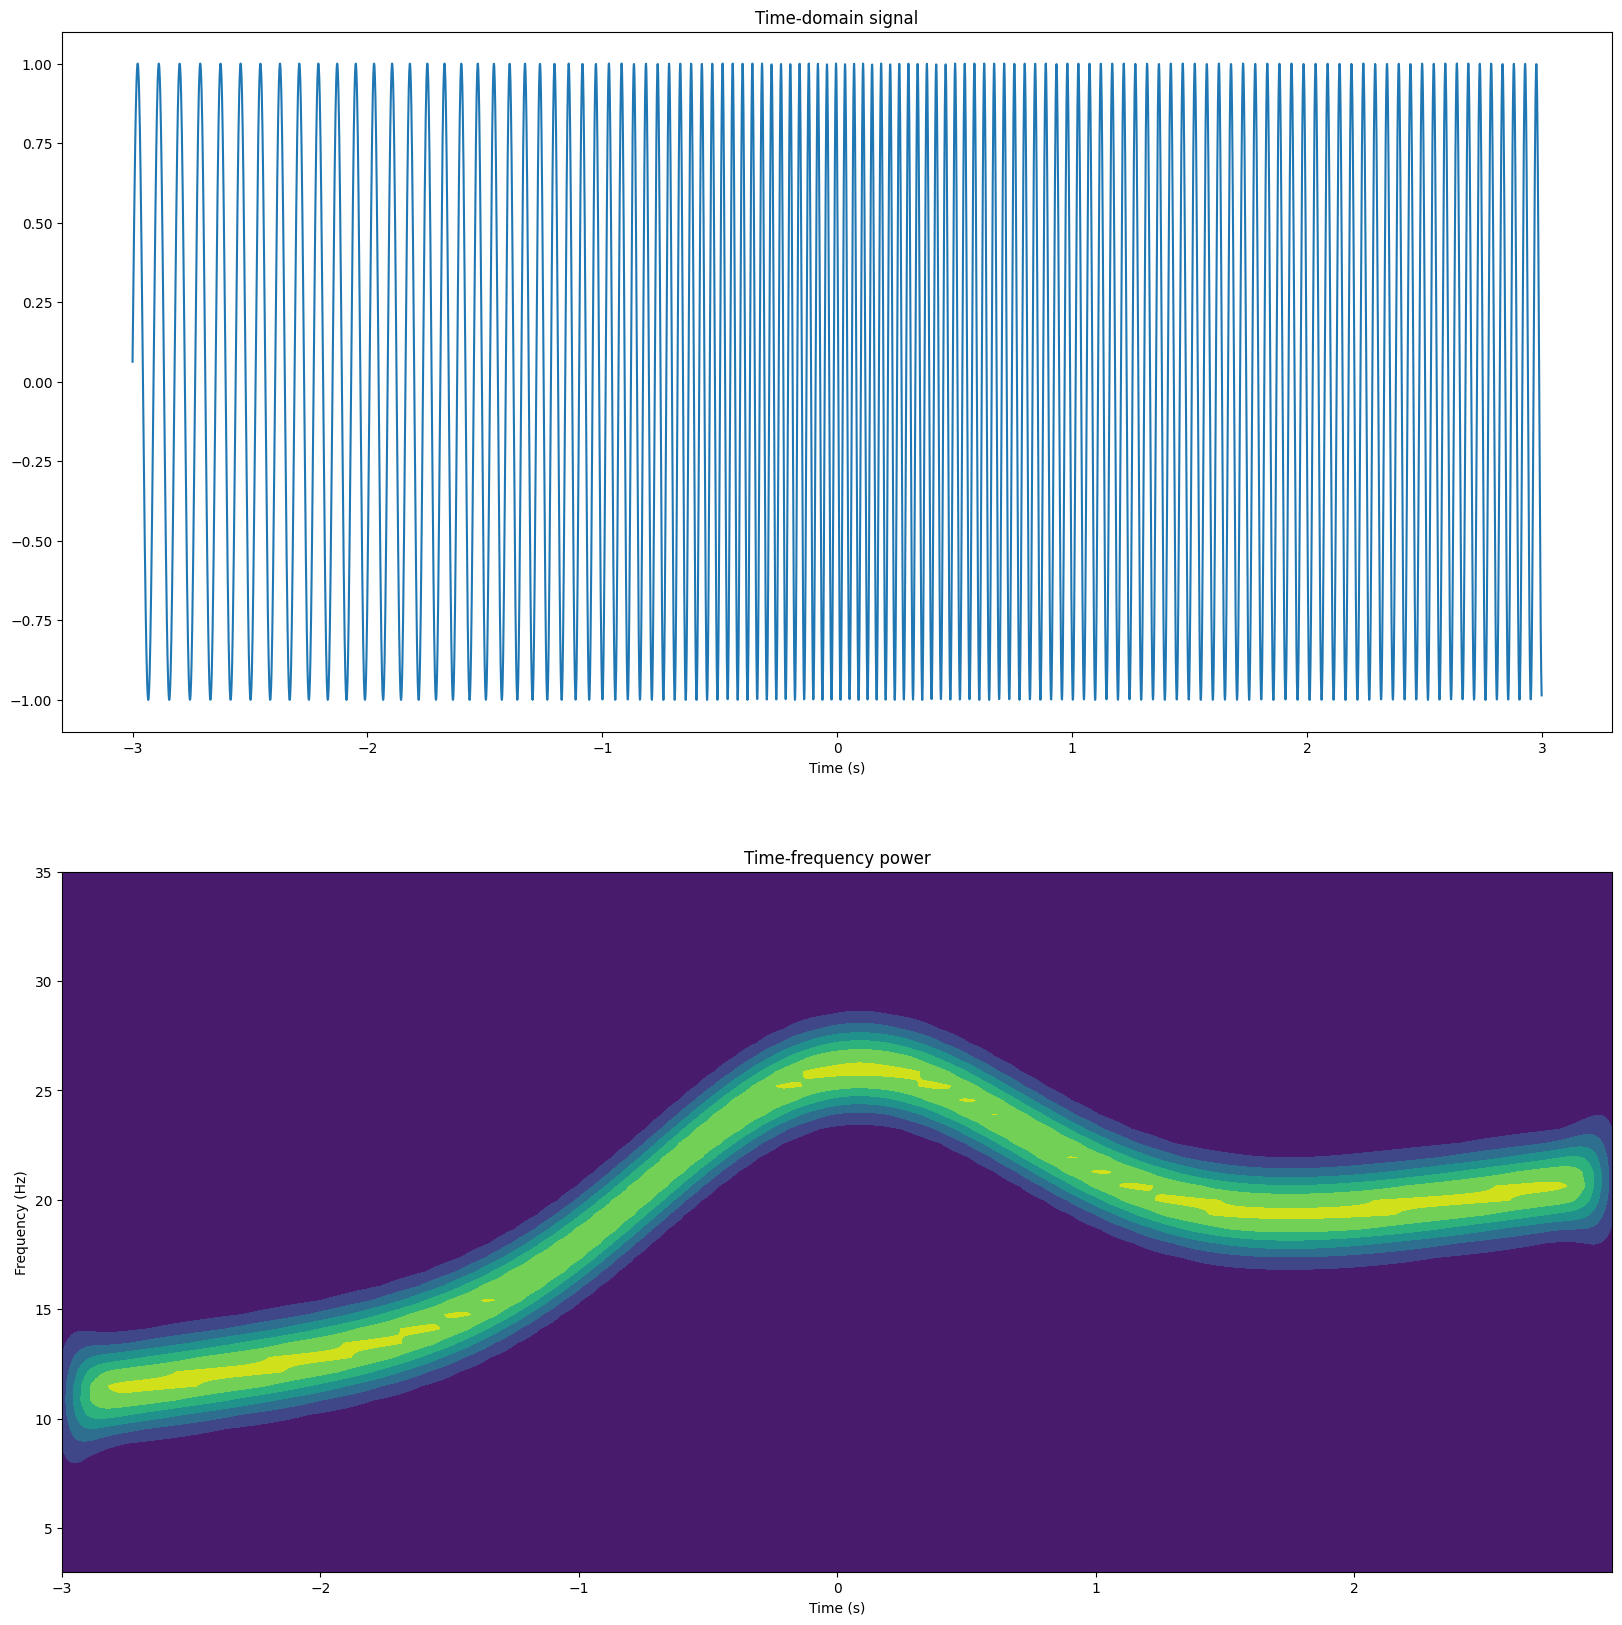

In [ ]:
srate = 1000
time_points = np.arange(-3, 3, 1/srate)
num_points = len(time_points)

# Модуляция частоты
freq_modulation = np.exp(-time_points**2) * 10 + 10
freq_modulation += np.linspace(0, 10, num_points)
signal = np.sin(2 * np.pi * (time_points + np.cumsum(freq_modulation) / srate))

# Расчет времени и частоты
num_frequencies = 50
frequency_values = np.linspace(3, 35, num_frequencies)
fwhm = 0.2
wavelets = np.zeros((num_frequencies, len(time_points)), dtype=complex)

for wi in range(0, num_frequencies):
    gauss = np.exp(-(4 * np.log(2) * time_points**2) / fwhm**2)
    wavelets[wi, :] = np.exp(1j*2*np.pi*frequency_values[wi] * time_points) * gauss

# Вычисление вейвлет-преобразования
convolution_size = num_points * 2 - 1
half_size = int(np.floor(num_points / 2) + 1)
signal_fft = scipy.fftpack.fft(signal, convolution_size)
tf_result = np.zeros((num_frequencies, len(time_points)))

for fi in range(0, num_frequencies):
    wavelet_fft = scipy.fftpack.fft(wavelets[fi,:], convolution_size)
    wavelet_fft = wavelet_fft / np.max(wavelet_fft)
    convolution_result = scipy.fftpack.ifft(wavelet_fft * signal_fft)
    convolution_result = convolution_result[half_size - 3 : -half_size]
    tf_result[fi, :] = np.abs(convolution_result)**2

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(time_points, signal)
plt.xlabel('Time (s)')
plt.title('Time-domain signal')

plt.subplot(2, 1, 2)
plt.contourf(time_points, frequency_values, tf_result)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.show()


Задание 5. Построить спектрограмму сигнала активности мозга (файл Lab6_Data.mat).
Использовать для реализации вейвлет Морле.


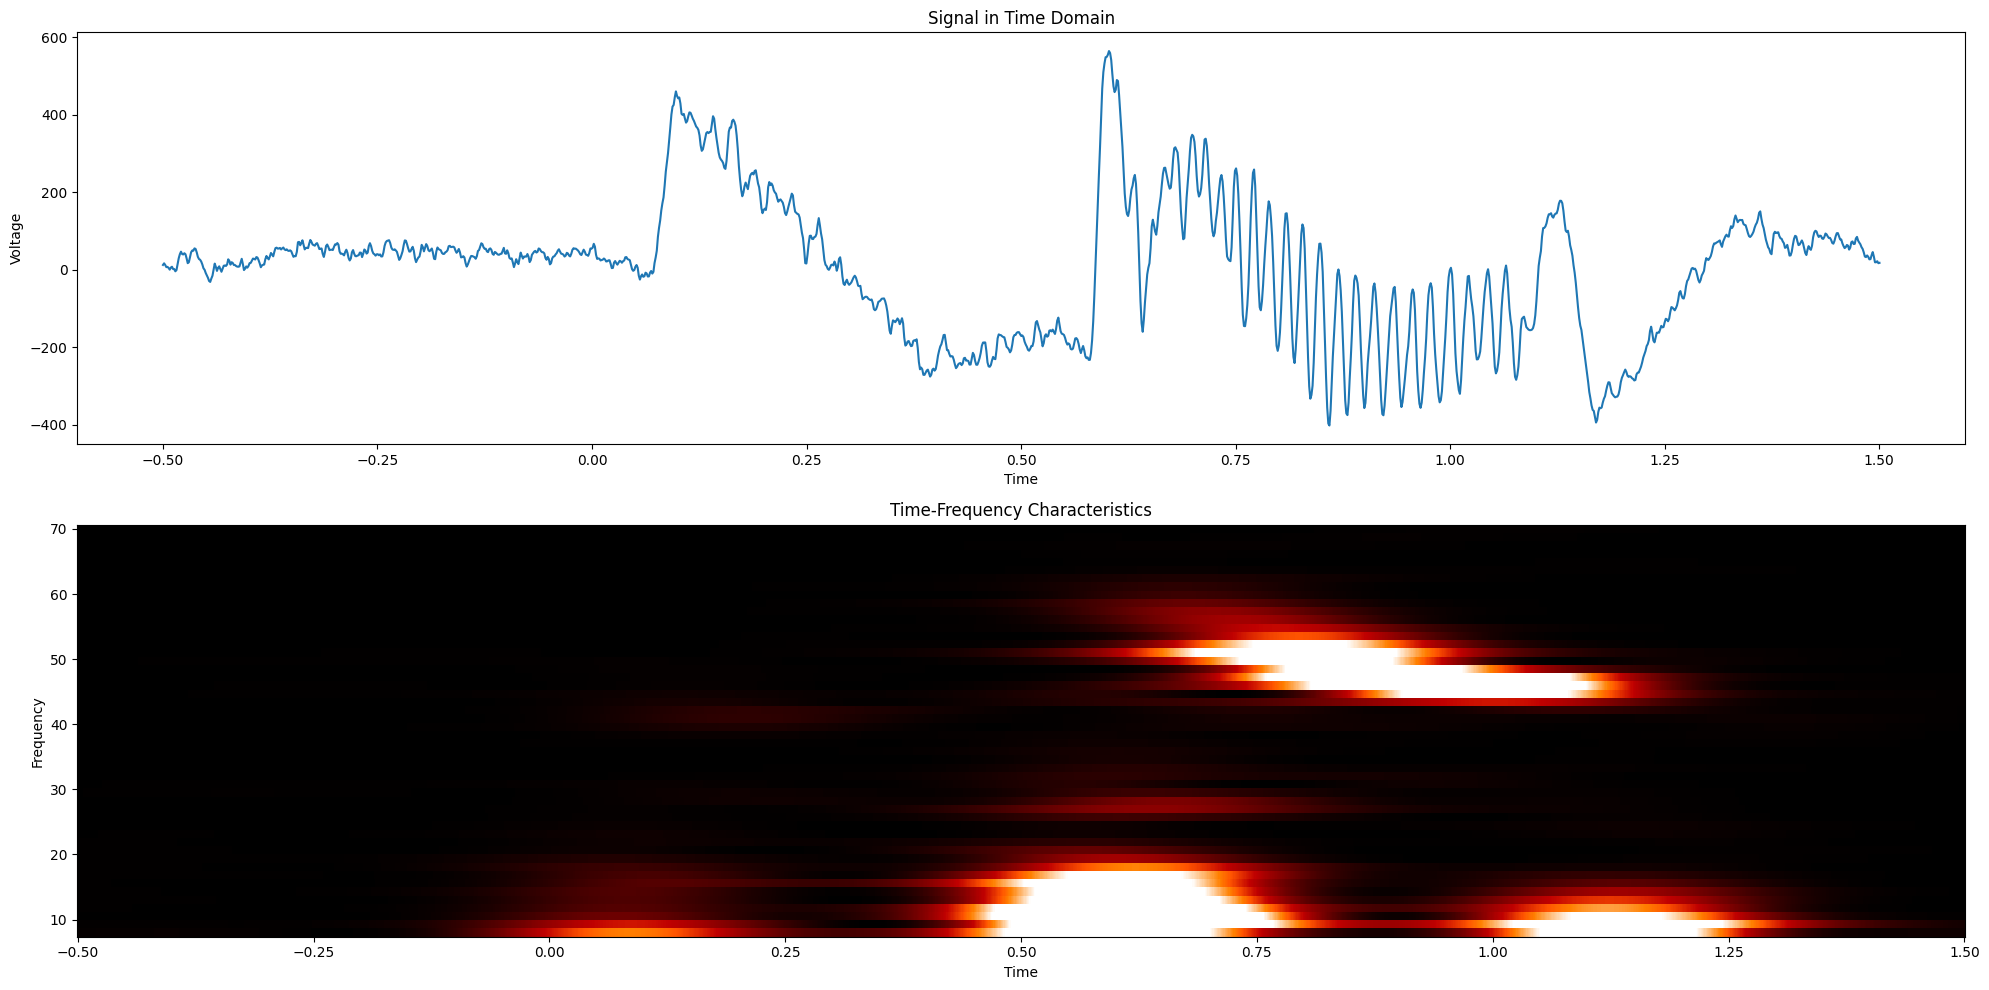

In [ ]:
brain_data = sio.loadmat(r'/content/drive/MyDrive/Colab Notebooks/Lab6_Data.mat')
time_vector = brain_data['timevec'][0]
sampling_rate = brain_data['srate'][0]
signal_data = brain_data['data'][0]

num_frequencies = 50
frequency_range = np.linspace(8, 70, num_frequencies)
half_wavelet_width = .2
wavelet_time = np.arange(-2, 2, 1 / sampling_rate)
wavelets = np.zeros((num_frequencies, len(wavelet_time)), dtype=complex)

for wi in range(0, num_frequencies):
    gaussian_window = np.exp(-((wavelet_time/half_wavelet_width)**2))
    wavelets[wi, :] = np.exp(1j*2*np.pi*frequency_range[wi] * wavelet_time) * gaussian_window

convolution_size = len(time_vector) + len(wavelet_time) - 1
half_convolution_size = int(np.floor(len(wavelet_time) / 2))
signal_fft = np.fft.fft(signal_data, convolution_size)
time_frequency_result = np.zeros((num_frequencies, len(time_vector)))

for fi in range(0, num_frequencies):
    wavelet_fft = np.fft.fft(wavelets[fi, :], convolution_size)
    wavelet_fft = wavelet_fft / np.max(wavelet_fft)
    convolution_result = np.fft.ifft(wavelet_fft * signal_fft)
    convolution_result = convolution_result[half_convolution_size-1 : -half_convolution_size]
    time_frequency_result[fi, :] = np.abs(convolution_result)**2

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(time_vector, signal_data)
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Signal in Time Domain')

plt.subplot(2, 1, 2)
plt.pcolormesh(time_vector, frequency_range, time_frequency_result, vmin=0, vmax=1e3, cmap='gist_heat')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Time-Frequency Characteristics')

plt.tight_layout()
plt.show()

Задание 5. Скачайте с интернета любой аудио
файл, постройте для него
спектрограмму используя вейвлет
Морле, вейвлет Хаара и вейвлет
“Мексиканская шляпа.

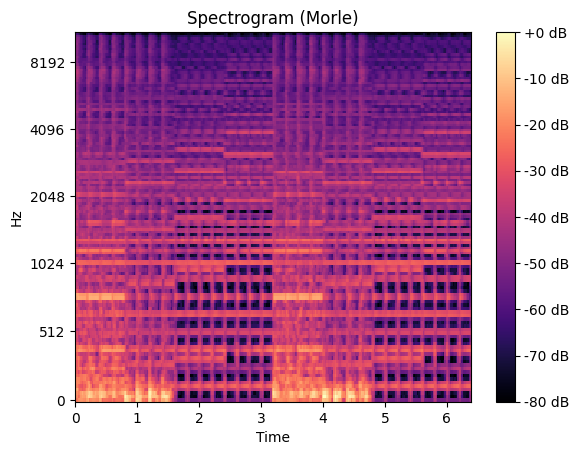

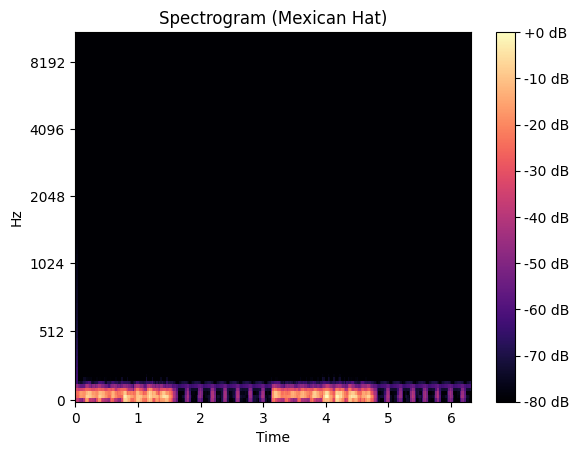

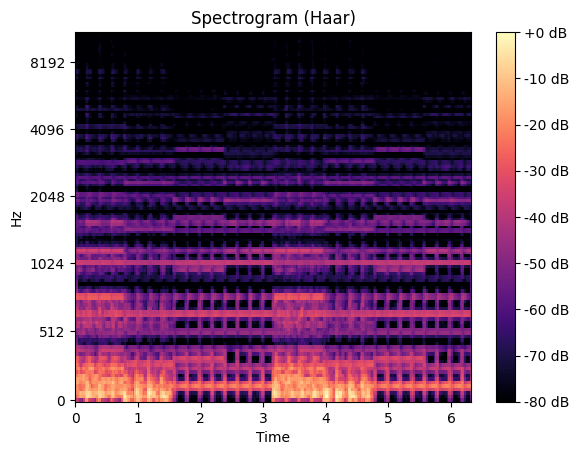

In [70]:
# Morle
y, sr = librosa.load('/content/sample-6s.mp3')
time = np.linspace(-2000, 2000, len(y))
spec = librosa.feature.melspectrogram(y=y, sr=sr)
spec_db = librosa.power_to_db(spec, ref=np.max)

# Mexican

time_vec = np.arange(-6, 6, 0.01)
y1_mh =([wavelet_function(t, wavelet_type="Mexican_hat") for t in time_vec])
y1_mh= np.convolve(y1_mh,y, mode = 'valid')
spec_mh = librosa.feature.melspectrogram(y=y1_mh, sr=sr)
spec_db_mh = librosa.power_to_db(spec_mh, ref=np.max)

# Haar
time_vec = np.arange(-6, 6, 0.01)
y1_haar = ([wavelet_function(t, wavelet_type="Haar") for t in time_vec])
y1_haar= np.convolve(y1_haar,y, mode = 'valid')
spec_haar = librosa.feature.melspectrogram(y=y1_haar, sr=sr)
spec_db_haar = librosa.power_to_db(spec_haar, ref=np.max)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
img = librosa.display.specshow(spec_db, x_axis='time', y_axis='mel', ax = ax)
fig.colorbar(img, ax = ax, format='%+2.0f dB')
ax.set_title('Spectrogram (Morle)')
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=1)
img_mh = librosa.display.specshow(spec_db_mh, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img_mh, ax=ax, format='%+2.0f dB')
ax.set_title('Spectrogram (Mexican Hat)')
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=1)
img_haar = librosa.display.specshow(spec_db_haar, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img_haar, ax=ax, format='%+2.0f dB')
ax.set_title('Spectrogram (Haar)')
fig.show()